In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from network import Approx, Dual, Lagrange, objective

load from checkpoint with iters:  500000


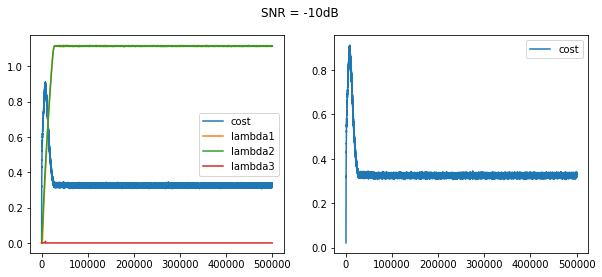

load from checkpoint with iters:  500000


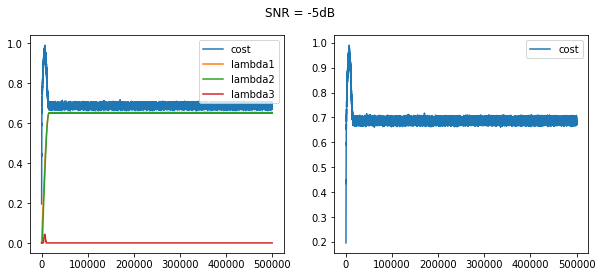

load from checkpoint with iters:  500000


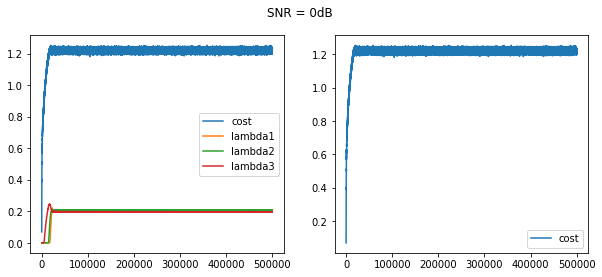

load from checkpoint with iters:  500000


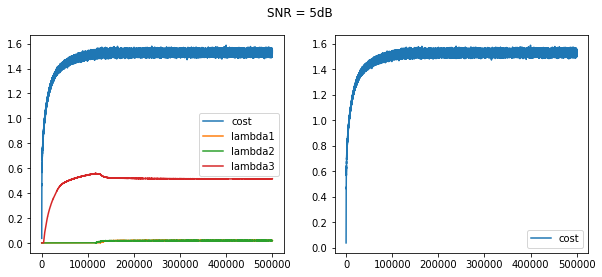

load from checkpoint with iters:  500000


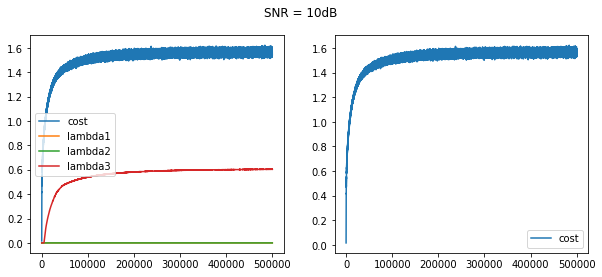

load from checkpoint with iters:  500000


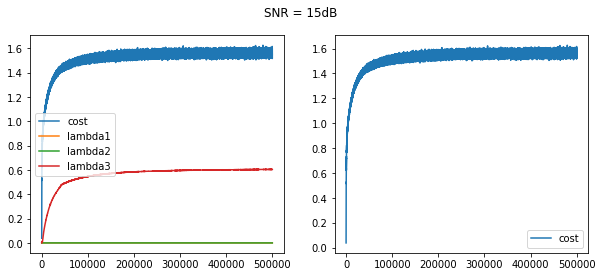

load from checkpoint with iters:  500000


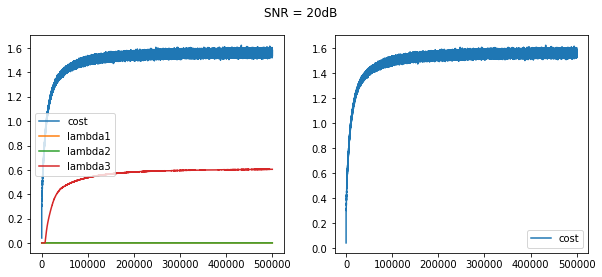

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '3,'

N = 2
val_batch_size = int(1e6)
val_sample_num = val_batch_size

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    
SNR= [-10, -5, 0, 5, 10, 15, 20]
save_path = ['./SNR_neg_10_quick', './SNR_neg_5_quick', './SNR_0_quick', './SNR_5_quick', './SNR_10_quick', \
             './SNR_15_quick', './SNR_20_quick',]
# SNR= [7]
# save_path = ['./SNR_7_quick',]

for i in range(len(save_path)):
    lastest_model, lastest_iters = get_lastest_model(path = save_path[i])
    if lastest_model is not None:
        iters = lastest_iters
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        y1 = checkpoint['val_cost']
        y2 = checkpoint['train_cost']
        x1 = checkpoint['lambda1']
        x2 = checkpoint['lambda2']
        x3 = checkpoint['lambda3']
        print('load from checkpoint with iters: ', iters)

        x = np.arange(iters)
        
        fig,axes = plt.subplots(1,2,figsize=(10,4))
        
        ax1=axes[0]
        ax1.plot(x,y1[0:iters], label = 'cost')
        #     ax1.plot(x,y2[0:iters+1])
        ax1.plot(x,x1[0:iters], label = 'lambda1')
        ax1.plot(x,x2[0:iters], label = 'lambda2')
        ax1.plot(x,x3[0:iters], label = 'lambda3')
        ax1.legend(loc='best')
        
        ax2 = axes[1]
        x = np.arange(len(y1))
        ax2.plot(x,y1, label = 'cost')
        ax2.legend(loc='best')
        
        fig.suptitle('SNR = '+ str(SNR[i]) + 'dB')
        plt.show()

load from checkpoint with iters:  500000
load from checkpoint with iters:  500000
load from checkpoint with iters:  500000
load from checkpoint with iters:  500000
load from checkpoint with iters:  500000
load from checkpoint with iters:  500000
load from checkpoint with iters:  500000


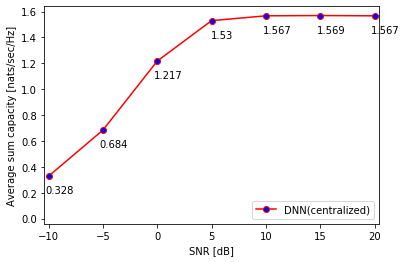

In [3]:
val_sample_num = int(1e6)

h_val_dataset = torch.zeros(val_sample_num, N)
h_val_dataset.exponential_(lambd=1)
g_val_dataset = torch.zeros(val_sample_num, N)
g_val_dataset.exponential_(lambd=1)

model_Approx = Approx(inp = 2*N, oup = N, hidden_dim = 10*N)

if use_gpu:
    model_Approx = nn.DataParallel(model_Approx)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_Approx = model_Approx.to(device)

cap = [None]*len(save_path)
approx_0db = None

for i in range(len(save_path)):
    lastest_model, lastest_iters = get_lastest_model(path = save_path[i])
    if lastest_model is not None:
        iters = lastest_iters
        checkpoint = torch.load(lastest_model, map_location=None if use_gpu else 'cpu')
        model_Approx.load_state_dict(checkpoint['state_approx_dict'], strict=True)
        print('load from checkpoint with iters: ', iters)
        
    model_Approx.eval()
    with torch.no_grad():
        h_data, g_data = h_val_dataset.to(device), g_val_dataset.to(device)

        approx = model_Approx(h_data, g_data)
        cap[i] = torch.mean(objective(approx, h_data))
        if SNR[i] == 0:
            approx_0db = approx
        
plt.plot(SNR, cap, color='r',markerfacecolor='blue',marker='o', label='DNN(centralized)')
plt.xlabel('SNR [dB]')
plt.ylabel('Average sum capacity [nats/sec/Hz]')
for a, b in zip(SNR, cap):
#     plt.text(a+1.0, b-0.15, (int(a),round(float(b), 2)),ha='center', va='bottom', fontsize=10)
    plt.text(a+1.0, b-0.15, round(float(b), 3),ha='center', va='bottom', fontsize=10)  

plt.legend(loc='lower right')
plt.xlim([-10-0.4, 20+0.4])
plt.ylim([0-0.04, 1.6+0.04])
plt.show()

1000000 1.2173146


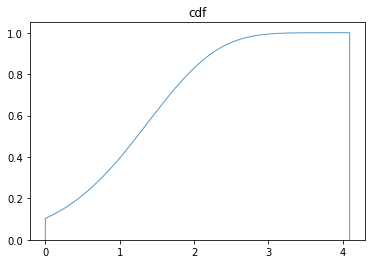

In [4]:
# a = approx_np[:,0] + approx_np[:,1]
a = objective(approx_0db, h_data)

a = a.data.cpu().numpy()

print(len(a), np.mean(a))
plt.plot()
plt.hist(a,100000,density = True,histtype='step',facecolor='pink',alpha=0.75,cumulative=True,rwidth=0.8)
plt.title("cdf")
plt.show()